In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

from balancers import BinaryBalancer, MulticlassBalancer
import tools

## Working with a binary predictor
### Checking for bias
First, let's load our data. Here we're using a synthetic dataset about pets that need some TLC. 

In [2]:
pets = pd.read_csv('data/farm_animals.csv')
pets.head()

,animal,action,pred_action,shear,shear_pred,shear_prob
0,dog,feed,feed,0,0,0.8917
1,dog,feed,pet,0,0,0.6248
2,cat,shear,shear,1,1,0.4187
3,dog,feed,feed,0,0,0.1347
4,sheep,feed,pet,0,0,0.2754


In the data, we have information about the kind of pet (`animal`), what it kind of care it needs (`action`), and what kind of care we think it needs (`pred_action`).

For the following examples, we'll use `animal` as our protected category. 

In [3]:
a = pets.animal.values

Next, we'll set the true outcome variable, `Y`. `action` is what each animal would like us to do, but it's a multiclass variable, so we'll pick one level and make sure we're fair with respect to that. Since shaving an animal has the potential to be traumatizing, let's go with `shear`.

In [4]:
y = np.array(pets.action == 'shear', dtype=np.uint8)

Our potentially biased predictor in this case will be `pred_action`. Let's call it `y_`.

In [5]:
y_ = np.array(pets.pred_action == 'shear', dtype=np.uint8)

Before stratifying by `animal`, let's start by seeing how good our predictions are overall. For that we'll use `tools.clf_metrics()`, which will generate lots of helpful statistics.

In [6]:
shear_stats = tools.clf_metrics(y, y_)

In [7]:
shear_stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,111.0,166.0,673.0,50.0,0.6894,0.8021,0.4007,0.9308,0.4915,0.5068,0.403724,0.216,0.0,0.0,161.0,277.0,116.0,0.7205


Overall, true positive rate (`sens`) is .69, and our false positive rate (1 - `spec`) is .20--not bad! Now let's see whether these results are balanced with respect to `animal`.

In [8]:
pb = BinaryBalancer(y=y, y_=y_, a=a)


Pre-adjustment group rates are 

group     fpr     tpr
  cat  0.1652  0.4419
  dog   0.258   0.641
sheep  0.1048  0.8481

And loss is 0.2160



Ah! We can see that the rates are pretty different across groups. In sheep, `tpr` and `fpr` are great--makes sense, since it's pretty easy to tell when to shave a sheep--but they're substantially worse for cats and dogs. 

### Adjusting biased predictions
Let's use the `.adjust()` method to see if we can achieve the same `fpr` and `tpr` (AKA equalized odds) across groups.

In [9]:
pb.adjust(goal='odds', summary=False)

`.adjust()` returns the theoretical optima for loss (1 - accuracy, in this case) and the ROC coordinates after adjustment. With equalized odds, the best we can do for all groups is a FPR of 18% and TPR of 45%, and loss goes up by about 6%.

The adjuster can also print the ROC coordinates for the model's empirical predictions on the original dataset (normally it does this by default, but we've supressed it here to keep the presentation clean). 

In [10]:
pb.summary(org=False)


Post-adjustment group rates are 

group     fpr     tpr
  cat  0.1829  0.4419
  dog  0.1835  0.4359
sheep  0.1774   0.443

And loss is 0.2430



Notice that the predicted rates are a bit different from the theoretical optima returned by `.adjust()`. The variability here comes from the `fpr` and `tpr` of the original predictor--the adjusted predictions come from randomly picking which of those original predictions to set to `1`, but since not all of those are perfect, we get a different blend of correct guesses each time, hence the movement in the realized rates. Despite this variability, the long-run averages for the rates will be the same, though, which is the best we can do with an oblivious predictor.

### Visualizing the predictions and the adjustments
The balancer's `.plot()` function shows all of this data in action.

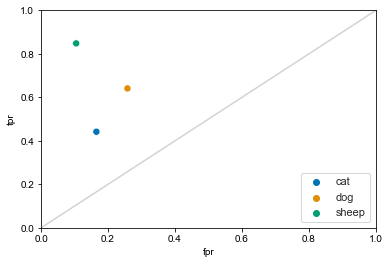

In [11]:
pb.plot(optimum=False, lp_lines=False)

Here we see the original three points in ROC space. The difference in `tpr` between all 3 groups is apparent, but especially so between cats and sheep.

If `.adjust()` has been called, `.plot()` will plot the optimum point (or line, in the case of equal opportunity) by default. In this case, the coordiante for the worst-performing group is achievable by adjusting for the others, and so that becomes the optimum for everyone.

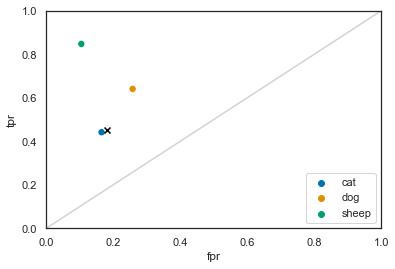

In [12]:
pb.plot(lp_lines=False)

To see how random sampling affects the error rates, we can plot the observed ROC coordinates for the adjusted predictions. Again, these are a bit different from the theoretical optimum, but over the long-run they'll average out correctly.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


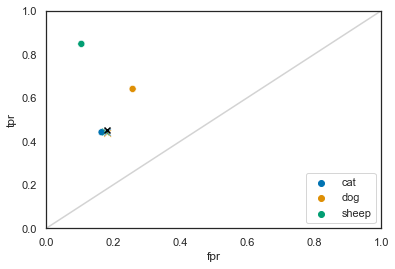

In [13]:
pb.plot(preds=True, lp_lines=False)

Finally, we can plot the convex hulls showing *all* of the achievable ROC points for each group. The intersection of the hulls are rates we can achieve for all groups at once, and the point in the intersection with the lowest loss (generally closest to the top left corner of the plot) is what the linear program in `.adjust()` picks as the optimum.

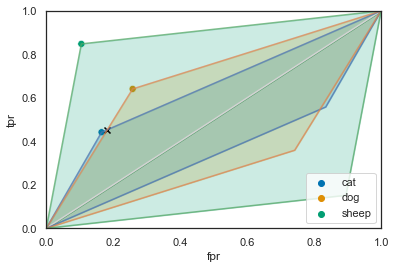

In [14]:
pb.plot()

The optimum is a bit hard to see, but zooming in shows the intersection nicely.

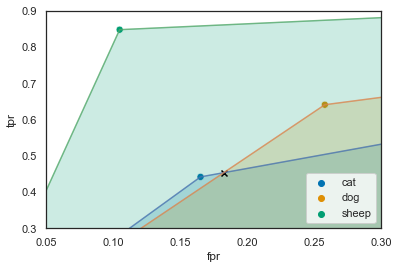

In [15]:
pb.plot(xlim=(0.05, .3), ylim=(.3, .9))

## Working with a real-valued predictor

The `PredictionBalancer` can also handle real-valued predictors (non-probabilistic scores are normalized to be betwee 0 and 1). Here, we'll use whether the animal needs to be shorn as our target, and we'll use the predicted shear probabilities (`shear_prob`) as our predictor.

In [16]:
pb_roc = BinaryBalancer(y=pets.shear, y_=pets.shear_prob, a=pets.animal)

Probabilities detected.


Pre-adjustment group rates are 

group     fpr     tpr
  cat  0.2537  0.7907
  dog  0.4202  0.8974
sheep  0.0565  0.8987

And loss is 0.2720



`tpr` looks relatively stable across groups, but there are some big differences in `fpr`, especially between dogs and sheep. Let apply the adjustment for equalized odds to see if we can do better.

In [17]:
pb_roc.adjust(goal='odds')


Post-adjustment group rates are 

group     fpr     tpr
  cat  0.3835  0.8605
  dog  0.3883  0.8205
sheep  0.4032  0.7848

And loss is 0.3560



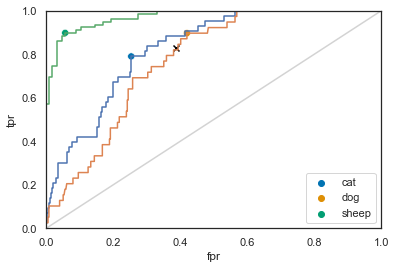

In [18]:
pb_roc.plot(lp_lines=False)

Using `.plot()` with `lp_lines` set to `True` will show the convex hulls corresponding to the thresholded predictions. Here, we'll drop the ROC curves to show the geometry of the solution more clearly.

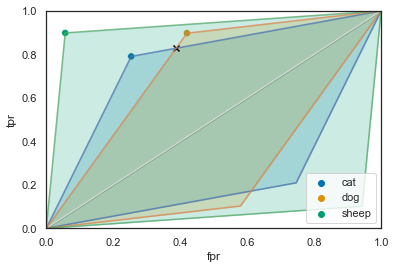

In [19]:
pb_roc.plot(roc_curves=False)

# Working with a multiclass predictor

## Instantiate and fit a new balancer

The `MulticlassBalancer` class does the same thing as the `BinaryBalancer`, only for predictors with more than two outcome levels. The original predictor in our farm animals dataset had three levels (pet, feed, and shear), so let's plug that in and see how the balancer works.

In [20]:
multi_y = pets.action.values
multi_y_ = pets.pred_action.values
multi_b = MulticlassBalancer(y=multi_y, y_=multi_y_, a=a)

In [21]:
multi_b.summary(adj=False)


Pre-adjustment group rates are 

cat
          fpr     tpr
feed   0.2280  0.7249
pet    0.1466  0.6133
shear  0.1652  0.4419

dog
          fpr     tpr
feed   0.0988  0.4032
pet    0.2603  0.8049
shear  0.2580  0.6410

sheep
          fpr     tpr
feed   0.0783  0.2841
pet    0.3772  0.7222
shear  0.1048  0.8481


And loss is 0.4080



Here we can see the FPRs and TPRs of the predictor for each outcome and for each group. There's a lot of disparity here, so let's try balancing for equalized odds.

In [22]:
multi_b.adjust(goal='odds')
multi_b.summary()


Pre-adjustment group rates are 

cat
          fpr     tpr
feed   0.2280  0.7249
pet    0.1466  0.6133
shear  0.1652  0.4419

dog
          fpr     tpr
feed   0.0988  0.4032
pet    0.2603  0.8049
shear  0.2580  0.6410

sheep
          fpr     tpr
feed   0.0783  0.2841
pet    0.3772  0.7222
shear  0.1048  0.8481


And loss is 0.4080


Post-adjustment rates for all groups are 

          fpr     tpr
feed   0.1995  0.3042
pet    0.5915  0.6961
shear  0.1044  0.2090

And loss is 0.5900



The outcome-specific FPRs and TPRs are now equal across groups, although it comes with a fairly stiff penalty in a ~18% loss in overall accuracy. There are a few other important adjustements we can try. First, equal opportunity, which only requires that TPR be the same for each outcome across groups.

In [23]:
multi_b.adjust(goal='opportunity')
multi_b.summary(org=False)


Post-adjustment group rates are 

cat
          fpr     tpr
feed   0.1293  0.4110
pet    0.1466  0.6133
shear  0.3810  0.5627


dog
          fpr     tpr
feed   0.2698  0.4110
pet    0.1983  0.6133
shear  0.2979  0.5627


sheep
          fpr     tpr
feed   0.3319  0.4110
pet    0.3204  0.6133
shear  0.0696  0.5627



And loss is 0.5021



Here, we get a different set of rates for each group, since we're allowing the FPRs to vary. Note, though, that the TPR column is the same across groups.

For a stricter kind of fairness, we can even require each cell of the adjusted confusion matrix to be the same across groups.

In [24]:
multi_b.adjust(goal='strict')
multi_b.summary(org=False)


Post-adjustment group rates are 

cat
          fpr     tpr
feed   0.0566  0.0962
pet    0.5958  0.7330
shear  0.2470  0.4877


dog
          fpr     tpr
feed   0.0564  0.0962
pet    0.6043  0.7330
shear  0.2551  0.4877


sheep
          fpr     tpr
feed   0.0522  0.0962
pet    0.5489  0.7330
shear  0.2576  0.4877



And loss is 0.6440



Here, we see that although the TPRs are the same, the FPRs are not--a counterintuitive result of the way the class-specific FPRs are calculated. However, checking the post-adjustment confusion matrices (or conditional probabilities) shows each of their cells is indeed the same across groups.

In [25]:
multi_b.new_cp_mats.round(4)

array([[[0.0962, 0.6261, 0.2778],
        [0.0587, 0.733 , 0.2084],
        [0.0493, 0.463 , 0.4877]],

       [[0.0962, 0.6261, 0.2778],
        [0.0587, 0.733 , 0.2084],
        [0.0493, 0.463 , 0.4877]],

       [[0.0962, 0.6261, 0.2778],
        [0.0587, 0.733 , 0.2084],
        [0.0493, 0.463 , 0.4877]]])

If we re-balance with equalized odds in mind, we can see that some of the off-diagonal cells are different, even though the outcome-specific FPRs are the same.

In [26]:
multi_b.adjust(goal='odds')
multi_b.new_cp_mats.round(4)

array([[[0.3042, 0.6189, 0.0769],
        [0.1649, 0.6961, 0.139 ],
        [0.3202, 0.4708, 0.209 ]],

       [[0.3042, 0.5786, 0.1172],
        [0.2259, 0.6961, 0.078 ],
        [0.1164, 0.6746, 0.209 ]],

       [[0.3042, 0.596 , 0.0999],
        [0.1885, 0.6961, 0.1154],
        [0.2045, 0.5864, 0.209 ]]])

These differences are small, but they highlight the importance of thinking carefully about the fairness constraint you choose to enforce before running the adjustment (or at least before using the adjusted predictor in practice on new data).

## Plotting multiclass results

The `.plot()` method of the `MulticlassBalancer` works the same was as it does for the `BinaryBalancer`, only it shows the convex hulls for all the outcomes instead of just one.

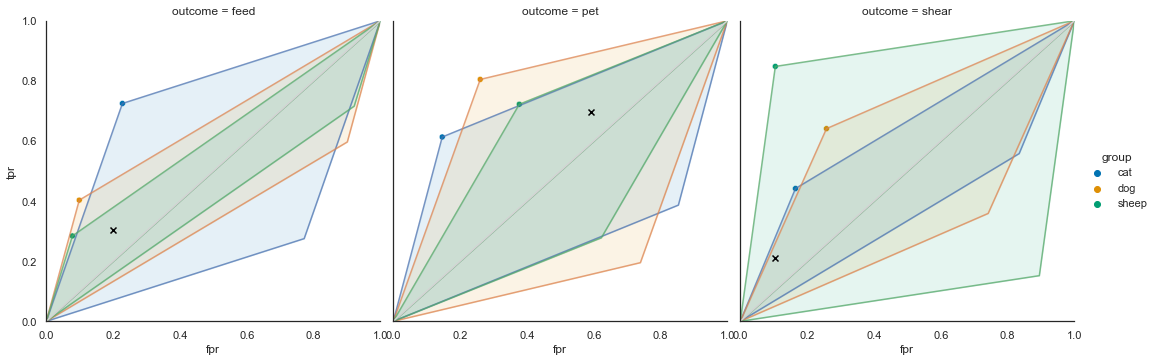

In [27]:
multi_b.plot()

Note that the outcome-specific optima are not actually guaranteed to be optimal. Where the balance point ends up in each space depends on the fairness constraint being enforced, the loss function being optimied, and the characteristics of the input data. Choosing a different constriant and loss function illustrates this point:

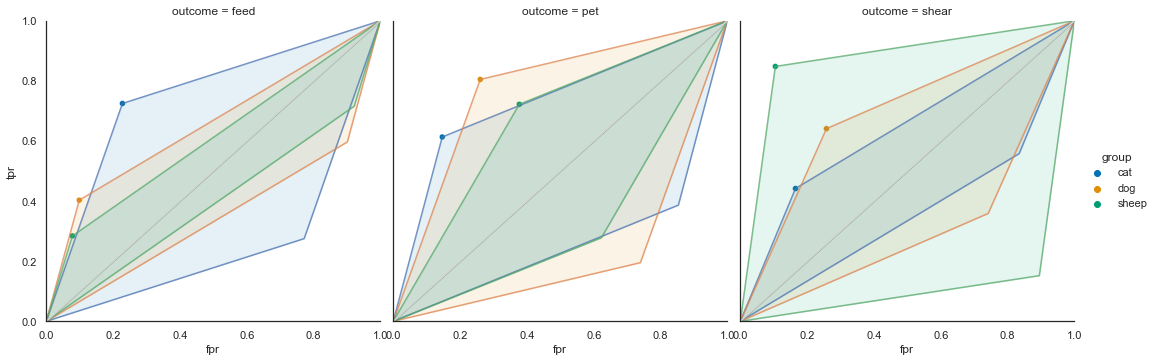

In [28]:
multi_b.adjust(goal='opportunity', loss='micro')
multi_b.plot()

Yikes! Where did the optima go? Well, one consequence of optimizing 'micro' loss, or raw accuracy, is that the fairest solution is sometimes to zero out one (or even all but one!) of the outcomes, i.e., to assign one outcome to every input. Checking the summary shows this is what happened here:

In [29]:
multi_b.summary(org=False)


Post-adjustment group rates are 

cat
       fpr  tpr
feed   1.0  1.0
pet    0.0  0.0
shear  0.0  0.0


dog
       fpr  tpr
feed   1.0  1.0
pet    0.0  0.0
shear  0.0  0.0


sheep
       fpr  tpr
feed   1.0  1.0
pet    0.0  0.0
shear  0.0  0.0



And loss is 0.4700



Because of the class imbalance in our dataset, the best adjustment, in terms of raw accuracy, was just to predict "feed" for every animal. In our paper, we call this a "trivial" solution, but whatever you call it, it's probably not very useful in practical situations. Let's rebalance with the same constraint, but go back to "macro" loss instead ("macro" is the default):

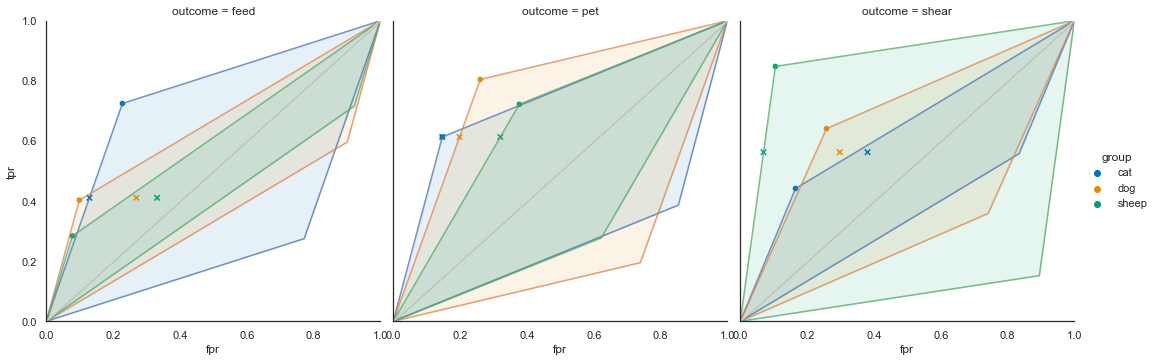

In [30]:
multi_b.adjust(goal='opportunity', loss='macro')
multi_b.plot()

Now we can see three separate optima for each outcome, one optimum for each kind of animal. Because we chose the equal opportunity constraint, all optima have the same TPR, but their FPRs are different.

## Generating predictions with cross-validation

Above, we used all of our data to solve the linear program for deriving the adjusted predictor. In the real world, though, we might not always know the true joint distribution of the variables Y, Y_, and A--in other words, if we use a random (potentially biased) sample of data to solve the LP, our fairness guarantee may not generalize well to other samples drawn from the same distribution. The `MulticlassBalancer` has some limited support for estimaitng this variability by way of cross-validation (see our [paper](http://ceur-ws.org/Vol-3087/paper_36.pdf) for more details).

To use cross-validation, need to run `.adjust` again, only this time with the `cv` parameter set to `True`.

In [31]:
multi_b.adjust(goal='odds', cv=True)
multi_b.summary()


Pre-adjustment group rates are 

cat
          fpr     tpr
feed   0.2280  0.7249
pet    0.1466  0.6133
shear  0.1652  0.4419

dog
          fpr     tpr
feed   0.0988  0.4032
pet    0.2603  0.8049
shear  0.2580  0.6410

sheep
          fpr     tpr
feed   0.0783  0.2841
pet    0.3772  0.7222
shear  0.1048  0.8481


And loss is 0.4080


Post-adjustment rates for all groups are 

          fpr     tpr
feed   0.1503  0.1958
pet    0.5819  0.6933
shear  0.1917  0.2791

And loss is 0.6371



Note that the the adjusted FPRs and TPRs are different from our prior attempt at equalized oddds, and the loss is much higher (64% instead of 50%). These changes come from the variance in the LP parameters induced by sampling and show that the performance of adjusted predictor may be much worse on average than its theoretical optimum.